<a href="https://colab.research.google.com/github/Stehen76/Exercise/blob/main/MultiText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Seeds
import random

# Processing
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df_es = pd.read_csv ('Violetta __ Omdena - Data.csv')
df_es.head(2)

,INPUTS,OUTPUTS,CATEGORY,Unnamed: 3,RELATIONSHIP,KEY WORDS
0,"Tuve relaciones sexuales con mi novia, se romp...",Es muy importante que no te adelantes a hechos...,Sexualidad,NaN,NaN,"ansiedad, embarazo, condón, papá, planeación f..."
1,Porque aveses siento que no soy lo suficientem...,Probablemente es la exigencia que tienes de ti...,Salud mental,NaN,Personal,"suficiente, bueno, valor"


In [ ]:
# Change column names so they are more readable
df_es = df_es.rename(columns={"INPUTS": "Question",
                              "OUTPUTS": "Answer",
                              "CATEGORY": "Label",
                              "Unnamed: 3": "Label2",
                              "RELATIONSHIP": "Relationship",
                              "KEY WORDS": "Key_words"})

# Take a look at data
df_es.iloc[:2]

,Question,Answer,Label,Label2,Relationship,Key_words
0,"Tuve relaciones sexuales con mi novia, se romp...",Es muy importante que no te adelantes a hechos...,Sexualidad,NaN,NaN,"ansiedad, embarazo, condón, papá, planeación f..."
1,Porque aveses siento que no soy lo suficientem...,Probablemente es la exigencia que tienes de ti...,Salud mental,NaN,Personal,"suficiente, bueno, valor"


In [ ]:
# make copy of DataFrame
df_es_copy = df_es.copy()

# change null values in 'Label' column with value 'Not_Label'
df_es_copy.loc[df_es_copy.Label.isnull(), "Label"] = "Not_Label"

# change null values in 'Label2' column with value 'Not_Label'
df_es_copy.loc[df_es_copy.Label2.isnull(), "Label2"] = "Not_Label"

# change null values in 'Relationship' column with value 'Not_Label'
df_es_copy.loc[df_es_copy.Relationship.isnull(), "Relationship"] = "Not_Label"

In [ ]:
from io import StringIO
col = ['Question', 'Label']
df_es_copy = df_es_copy[col]
df_es_copy = df_es_copy[pd.notnull(df_es_copy['Question'])]
df_es_copy.columns = ['Question', 'Label']
df_es_copy['category_id'] = df_es_copy['Label'].factorize()[0]
category_id_df = df_es_copy[['Label', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df.head()

,Label,category_id
0,Sexualidad,0
1,Salud mental,1
2,Not_Label,2
4,V. Psicologica,3
5,Indicador psicologico,4


In [ ]:
#Convert into a dictionary
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)
df_es_copy.head()

,Question,Label,category_id
0,"Tuve relaciones sexuales con mi novia, se romp...",Sexualidad,0
1,Porque aveses siento que no soy lo suficientem...,Salud mental,1
2,Que es para ti la vida?,Not_Label,2
3,La depresión es quedarte en tu cama llorando.?,Not_Label,2
4,¿Porque una persona es capaz de decir que te q...,V. Psicologica,3


**Distribution**
Show Imbalance data

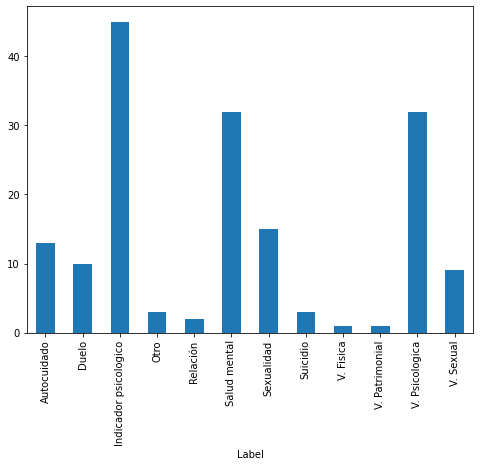

In [ ]:
fig = plt.figure(figsize=(8,6))
df_es.groupby('Label').Question.count().plot.bar(ylim=0)
plt.show()

**Main Words (Unigrams and bigrams) Representation by Label/Category of Violence**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
es_stopwords =  set(stopwords.words('spanish'))

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=es_stopwords)
features = tfidf.fit_transform(df_es_copy.Question).toarray()
labels = df_es_copy.category_id
features.shape

(4216, 1677)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

In [ ]:
N = 2
for Label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Autocuidado':
  . Most correlated unigrams:
. mejorar
. alrededor
  . Most correlated bigrams:
. dejar ser
. si bien
# 'Duelo':
  . Most correlated unigrams:
. regrese
. olvidar
  . Most correlated bigrams:
. ex novia
. puedo hacer
# 'Indicador psicologico':
  . Most correlated unigrams:
. suficientemente
. casado
  . Most correlated bigrams:
. día siguiente
. veces siento
# 'Not_Label':
  . Most correlated unigrams:
. alrededor
. suficientemente
  . Most correlated bigrams:
. día siguiente
. novio hace
# 'Otro':
  . Most correlated unigrams:
. nuevo
. duele
  . Most correlated bigrams:
. cómo puedo
. puedo hacer
# 'Relación':
  . Most correlated unigrams:
. pareja
. tratado
  . Most correlated bigrams:
. ser feliz
. puedo sentirme
# 'Salud mental':
  . Most correlated unigrams:
. sueño
. ansiosa
  . Most correlated bigrams:
. controlar emociones
. puedo ayudar
# 'Sexualidad':
  . Most correlated unigrams:
. conseguir
. pornografia
  . Most correlated bigrams:
. puedo dejar
. ganas 

**Naive Bayes Classifier**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_es_copy['Question'], df_es_copy['Label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["¿Porque una persona es capaz de decir que te quiere y que le importas y luego hacer cosas que atentan contra ti porque sabe que te lastiman? Como es que las personas son capaces de mentir de esa manera, de involucrarse y fingir que les importas y que les interesa conocerte y mientras hacen eso al mismo tiempo te mienten y tratan de hacer cosas que te hagan sentir mal?"])))

['Not_Label']


In [ ]:
print(clf.predict(count_vect.transform(["he escrito este hilo infinidad de veces y lo he borrado siempre, por miedo al juicio social, a mi ex y a la estigmatiza…"])))

['Not_Label']


**Models Accuracy**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.960152
LogisticRegression        0.960626
MultinomialNB             0.960626
RandomForestClassifier    0.960626
Name: accuracy, dtype: float64